Loading grids ... 
Interpolating ... Flow field loaded
SCCM value at x = 15 mm 2.069653806224516
SCCM value at x = 35 mm 2.0309878511005346
SCCM value at x = 88.6 mm 1.9159221950764214
x is the axial direction i.e. the direction that molecules propagate


C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 


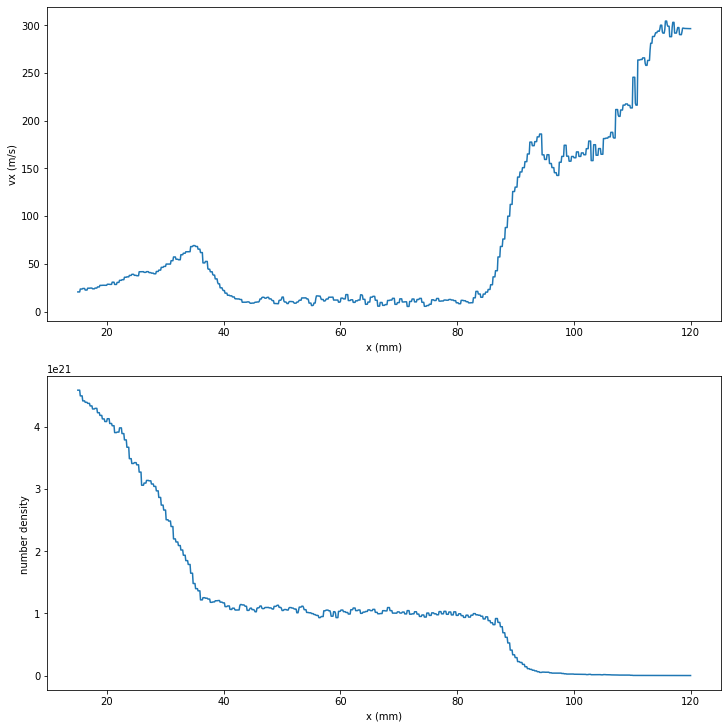

In [45]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

FF = 'flows/T_Cell/DS2t250-1.DAT'
#flowField = np.loadtxt(filename, skiprows=1)

def set_flow_type(FF):
        '''
        Loads DSMC output file FF and uses bivariate spline method to set gas characteristics
        on a grid of points.

        Args:
        FF is the filename of the DSMC output file (DS2FF.DAT) which should be named in the format
        xyyy.dat, where x denotes the geometry and yyy denotes the gas flow-rate. e.g. f005.dat

        The class instance will update the following attributes:
        # self._geometry: cell geometry, denoted by a single letter ('f', 'g', 'h', etc)
        # self._flowrate: buffer gas flowrate of the DSMC simulation, in SCCM.

        # self._fDens, self._fTemp, self._fVz, self._fVr, self._fVp: the scipy.interpolate objects
        corresponding to the density, temperature, etc. on the grid.

        **IMPORTANT: this method needs to be updated with each new designed cell geometry, depending
        on the desired size and coarseness of the simulation site.
        '''
        try:
            #Geometry is a string in ['fCell', 'gCell', 'hCell', ..., 'pCell', 'rCell', ...]
            #Flowrate is an integer in [2, 5, ..., 200] (SCCM)

            geometry = 'tCell'

            # print("Loading flow field: geometry {0}, flowrate {1} SCCM".format(geometry,self._flowrate))

            flowField = np.loadtxt(FF, skiprows=1) # Assumes only first row is not data.

            zs, rs, dens, temps = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7] #Arrays of z and r coordinates, density and temperature
            vzs, vrs, vps = flowField[:, 4], flowField[:, 5], flowField[:, 6] #velocity field in z, r, and "perpendicular" directions
            quantHolder = [zs, rs, dens, temps, vzs, vrs, vps]

            if geometry in ['fCell', 'gCell', 'nCell', 'qCell', 'rCell']:
                grid_x, grid_y = np.mgrid[0.010:0.12:2250j, 0:0.030:750j] # high density, to be safe. Was 4500 x 1500 points
            elif geometry in ['hCell', 'jCell', 'kCell', 'mCell']:
                grid_x, grid_y = np.mgrid[0.010:0.24:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['pCell']:
                grid_x, grid_y = np.mgrid[0.010:0.20:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['tCell', 'sCell', 'yCell']: # cases added by Ben, 2/19/2020
                grid_x, grid_y = np.mgrid[0.005:0.12:4500j, 0:0.030:1000j]
            else:
                raise ValueError('Unknown geometry')

            print("Loading grids ... ")
            grid_dens = si.griddata(np.transpose([zs, rs]), np.log(dens + 1.0), (grid_x, grid_y), 'nearest') # the +1.0 inside the log is to make sure the log-density never goes negative.
            grid_temps = si.griddata(np.transpose([zs, rs]), temps, (grid_x, grid_y), 'nearest')
            grid_vzs = si.griddata(np.transpose([zs, rs]), vzs, (grid_x, grid_y), 'nearest')
            grid_vrs = si.griddata(np.transpose([zs, rs]), vrs, (grid_x, grid_y), 'nearest')
            grid_vps = si.griddata(np.transpose([zs, rs]), vps, (grid_x, grid_y), 'nearest')

            print("Interpolating ... ",end='')
            fDens = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_dens, kx=1, ky=1)
            fTemp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_temps, kx=1, ky=1)
            fVz = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vzs, kx=1, ky=1)
            fVr = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vrs, kx=1, ky=1)
            fVp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vps, kx=1, ky=1)

            print("Flow field loaded")
            return fDens, fTemp, fVz, fVr, fVp

        except:
            raise ValueError('Could not load flow field')

            
def dsmc_quant(x0, y0, z0):
        '''
        Return quantity (quant) evaluated at the given location in the cell.

        Note: density is stored as log(dens) in self._fDens, so need to return exp().
        '''
       
        logdens = fDens(z0, (x0**2 + y0**2)**0.5).T[0]
        dens =  np.exp(logdens)


        tem = fTemp(z0, (x0**2 + y0**2)**0.5).T[0]

        Vz = fVz(z0, (x0**2 + y0**2)**0.5).T[0]
        vr = fVr(z0, (x0**2 + y0**2)**0.5).T[0]
        vPerpCw = fVp(z0, (x0**2 + y0**2)**0.5).T[0]
        theta = np.arctan2(y0, x0)
        rot = np.pi/2 - theta
        Vx = np.cos(rot) * vPerpCw + np.sin(rot) * vr
        Vy = -np.sin(rot) * vPerpCw + np.cos(rot) * vr
        
        return dens, tem, Vz, vr, Vx, Vy
    
def Integrand(x,z, fVz1, fDens1):
    return 2*np.pi*x*fVz1(z,x)[0][0]*np.exp(fDens1(z, x)[0][0])
    
    
fDens, fTemp, fVz, fVr, fVp = set_flow_type(FF)

zlinspace = np.linspace(0.015,0.12, 1000)
dens, tem, Vz, vr, Vx, Vy = dsmc_quant(0, 0, zlinspace)

fVz1 = fVz
fDens1 = fDens
z = 0.015
SCCM1 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.035
SCCM2 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.0886
SCCM3 = integrate.quad(Integrand, 0,0.0025, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
print("SCCM value at x = 15 mm", SCCM1 )
print("SCCM value at x = 35 mm", SCCM2 )
print("SCCM value at x = 88.6 mm", SCCM3 )

fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(zlinspace*1000, Vz) 
ax2.plot(zlinspace*1000, dens)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('number density ')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

Loading grids ... 
Interpolating ... Flow field loaded
SCCM value at x = 15 mm 1.1661007075686927
SCCM value at x = 35 mm 1.1172025574997684
SCCM value at x = 88.6 mm 1.1949310755438816
x is the axial direction i.e. the direction that molecules propagate


C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 


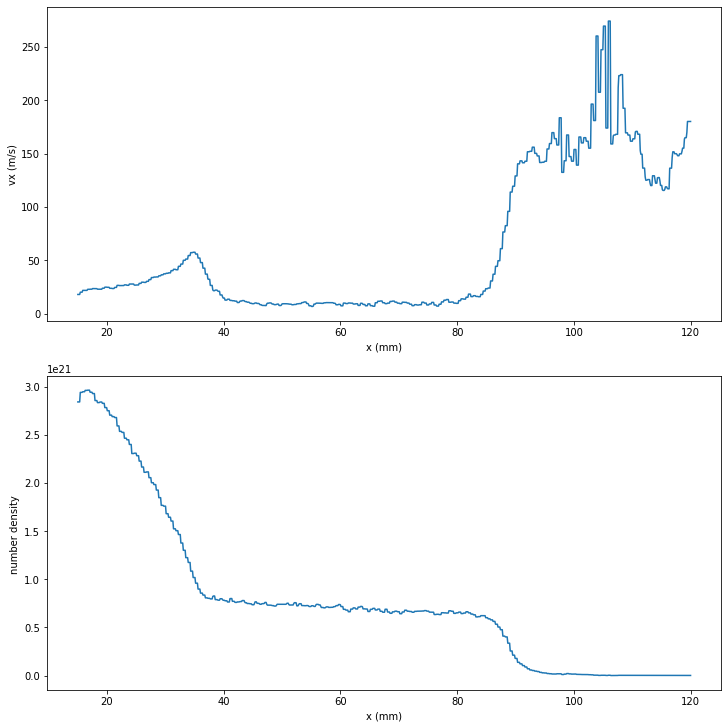

In [46]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

FF = 'flows/T_Cell/DS2t250-2.DAT'
#flowField = np.loadtxt(filename, skiprows=1)

def set_flow_type(FF):
        '''
        Loads DSMC output file FF and uses bivariate spline method to set gas characteristics
        on a grid of points.

        Args:
        FF is the filename of the DSMC output file (DS2FF.DAT) which should be named in the format
        xyyy.dat, where x denotes the geometry and yyy denotes the gas flow-rate. e.g. f005.dat

        The class instance will update the following attributes:
        # self._geometry: cell geometry, denoted by a single letter ('f', 'g', 'h', etc)
        # self._flowrate: buffer gas flowrate of the DSMC simulation, in SCCM.

        # self._fDens, self._fTemp, self._fVz, self._fVr, self._fVp: the scipy.interpolate objects
        corresponding to the density, temperature, etc. on the grid.

        **IMPORTANT: this method needs to be updated with each new designed cell geometry, depending
        on the desired size and coarseness of the simulation site.
        '''
        try:
            #Geometry is a string in ['fCell', 'gCell', 'hCell', ..., 'pCell', 'rCell', ...]
            #Flowrate is an integer in [2, 5, ..., 200] (SCCM)

            geometry = 'tCell'

            # print("Loading flow field: geometry {0}, flowrate {1} SCCM".format(geometry,self._flowrate))

            flowField = np.loadtxt(FF, skiprows=1) # Assumes only first row is not data.

            zs, rs, dens, temps = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7] #Arrays of z and r coordinates, density and temperature
            vzs, vrs, vps = flowField[:, 4], flowField[:, 5], flowField[:, 6] #velocity field in z, r, and "perpendicular" directions
            quantHolder = [zs, rs, dens, temps, vzs, vrs, vps]

            if geometry in ['fCell', 'gCell', 'nCell', 'qCell', 'rCell']:
                grid_x, grid_y = np.mgrid[0.010:0.12:2250j, 0:0.030:750j] # high density, to be safe. Was 4500 x 1500 points
            elif geometry in ['hCell', 'jCell', 'kCell', 'mCell']:
                grid_x, grid_y = np.mgrid[0.010:0.24:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['pCell']:
                grid_x, grid_y = np.mgrid[0.010:0.20:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['tCell', 'sCell', 'yCell']: # cases added by Ben, 2/19/2020
                grid_x, grid_y = np.mgrid[0.005:0.12:4500j, 0:0.030:1000j]
            else:
                raise ValueError('Unknown geometry')

            print("Loading grids ... ")
            grid_dens = si.griddata(np.transpose([zs, rs]), np.log(dens + 1.0), (grid_x, grid_y), 'nearest') # the +1.0 inside the log is to make sure the log-density never goes negative.
            grid_temps = si.griddata(np.transpose([zs, rs]), temps, (grid_x, grid_y), 'nearest')
            grid_vzs = si.griddata(np.transpose([zs, rs]), vzs, (grid_x, grid_y), 'nearest')
            grid_vrs = si.griddata(np.transpose([zs, rs]), vrs, (grid_x, grid_y), 'nearest')
            grid_vps = si.griddata(np.transpose([zs, rs]), vps, (grid_x, grid_y), 'nearest')

            print("Interpolating ... ",end='')
            fDens = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_dens, kx=1, ky=1)
            fTemp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_temps, kx=1, ky=1)
            fVz = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vzs, kx=1, ky=1)
            fVr = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vrs, kx=1, ky=1)
            fVp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vps, kx=1, ky=1)

            print("Flow field loaded")
            return fDens, fTemp, fVz, fVr, fVp

        except:
            raise ValueError('Could not load flow field')

            
def dsmc_quant(x0, y0, z0):
        '''
        Return quantity (quant) evaluated at the given location in the cell.

        Note: density is stored as log(dens) in self._fDens, so need to return exp().
        '''
       
        logdens = fDens(z0, (x0**2 + y0**2)**0.5).T[0]
        dens =  np.exp(logdens)


        tem = fTemp(z0, (x0**2 + y0**2)**0.5).T[0]

        Vz = fVz(z0, (x0**2 + y0**2)**0.5).T[0]
        vr = fVr(z0, (x0**2 + y0**2)**0.5).T[0]
        vPerpCw = fVp(z0, (x0**2 + y0**2)**0.5).T[0]
        theta = np.arctan2(y0, x0)
        rot = np.pi/2 - theta
        Vx = np.cos(rot) * vPerpCw + np.sin(rot) * vr
        Vy = -np.sin(rot) * vPerpCw + np.cos(rot) * vr
        
        return dens, tem, Vz, vr, Vx, Vy
    
def Integrand(x,z, fVz1, fDens1):
    return 2*np.pi*x*fVz1(z,x)[0][0]*np.exp(fDens1(z, x)[0][0])
    
    
fDens, fTemp, fVz, fVr, fVp = set_flow_type(FF)

zlinspace = np.linspace(0.015,0.12, 1000)
dens, tem, Vz, vr, Vx, Vy = dsmc_quant(0, 0, zlinspace)

fVz1 = fVz
fDens1 = fDens
z = 0.015
SCCM1 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.035
SCCM2 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.0886
SCCM3 = integrate.quad(Integrand, 0,0.0025, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
print("SCCM value at x = 15 mm", SCCM1 )
print("SCCM value at x = 35 mm", SCCM2 )
print("SCCM value at x = 88.6 mm", SCCM3 )

fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(zlinspace*1000, Vz) 
ax2.plot(zlinspace*1000, dens)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('number density ')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

Loading grids ... 
Interpolating ... Flow field loaded
SCCM value at x = 15 mm 4.040083585290593
SCCM value at x = 35 mm 4.341821635644849
SCCM value at x = 88.6 mm 4.270868652814797
x is the axial direction i.e. the direction that molecules propagate


C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 


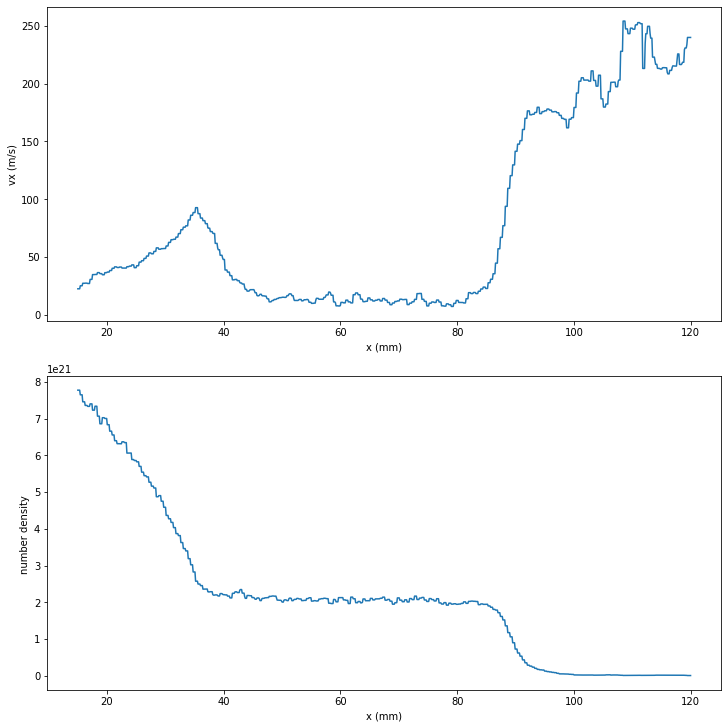

In [47]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

FF = 'flows/T_Cell/DS2t250-3.DAT'
#flowField = np.loadtxt(filename, skiprows=1)

def set_flow_type(FF):
        '''
        Loads DSMC output file FF and uses bivariate spline method to set gas characteristics
        on a grid of points.

        Args:
        FF is the filename of the DSMC output file (DS2FF.DAT) which should be named in the format
        xyyy.dat, where x denotes the geometry and yyy denotes the gas flow-rate. e.g. f005.dat

        The class instance will update the following attributes:
        # self._geometry: cell geometry, denoted by a single letter ('f', 'g', 'h', etc)
        # self._flowrate: buffer gas flowrate of the DSMC simulation, in SCCM.

        # self._fDens, self._fTemp, self._fVz, self._fVr, self._fVp: the scipy.interpolate objects
        corresponding to the density, temperature, etc. on the grid.

        **IMPORTANT: this method needs to be updated with each new designed cell geometry, depending
        on the desired size and coarseness of the simulation site.
        '''
        try:
            #Geometry is a string in ['fCell', 'gCell', 'hCell', ..., 'pCell', 'rCell', ...]
            #Flowrate is an integer in [2, 5, ..., 200] (SCCM)

            geometry = 'tCell'

            # print("Loading flow field: geometry {0}, flowrate {1} SCCM".format(geometry,self._flowrate))

            flowField = np.loadtxt(FF, skiprows=1) # Assumes only first row is not data.

            zs, rs, dens, temps = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7] #Arrays of z and r coordinates, density and temperature
            vzs, vrs, vps = flowField[:, 4], flowField[:, 5], flowField[:, 6] #velocity field in z, r, and "perpendicular" directions
            quantHolder = [zs, rs, dens, temps, vzs, vrs, vps]

            if geometry in ['fCell', 'gCell', 'nCell', 'qCell', 'rCell']:
                grid_x, grid_y = np.mgrid[0.010:0.12:2250j, 0:0.030:750j] # high density, to be safe. Was 4500 x 1500 points
            elif geometry in ['hCell', 'jCell', 'kCell', 'mCell']:
                grid_x, grid_y = np.mgrid[0.010:0.24:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['pCell']:
                grid_x, grid_y = np.mgrid[0.010:0.20:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['tCell', 'sCell', 'yCell']: # cases added by Ben, 2/19/2020
                grid_x, grid_y = np.mgrid[0.005:0.12:4500j, 0:0.030:1000j]
            else:
                raise ValueError('Unknown geometry')

            print("Loading grids ... ")
            grid_dens = si.griddata(np.transpose([zs, rs]), np.log(dens + 1.0), (grid_x, grid_y), 'nearest') # the +1.0 inside the log is to make sure the log-density never goes negative.
            grid_temps = si.griddata(np.transpose([zs, rs]), temps, (grid_x, grid_y), 'nearest')
            grid_vzs = si.griddata(np.transpose([zs, rs]), vzs, (grid_x, grid_y), 'nearest')
            grid_vrs = si.griddata(np.transpose([zs, rs]), vrs, (grid_x, grid_y), 'nearest')
            grid_vps = si.griddata(np.transpose([zs, rs]), vps, (grid_x, grid_y), 'nearest')

            print("Interpolating ... ",end='')
            fDens = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_dens, kx=1, ky=1)
            fTemp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_temps, kx=1, ky=1)
            fVz = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vzs, kx=1, ky=1)
            fVr = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vrs, kx=1, ky=1)
            fVp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vps, kx=1, ky=1)

            print("Flow field loaded")
            return fDens, fTemp, fVz, fVr, fVp

        except:
            raise ValueError('Could not load flow field')

            
def dsmc_quant(x0, y0, z0):
        '''
        Return quantity (quant) evaluated at the given location in the cell.

        Note: density is stored as log(dens) in self._fDens, so need to return exp().
        '''
       
        logdens = fDens(z0, (x0**2 + y0**2)**0.5).T[0]
        dens =  np.exp(logdens)


        tem = fTemp(z0, (x0**2 + y0**2)**0.5).T[0]

        Vz = fVz(z0, (x0**2 + y0**2)**0.5).T[0]
        vr = fVr(z0, (x0**2 + y0**2)**0.5).T[0]
        vPerpCw = fVp(z0, (x0**2 + y0**2)**0.5).T[0]
        theta = np.arctan2(y0, x0)
        rot = np.pi/2 - theta
        Vx = np.cos(rot) * vPerpCw + np.sin(rot) * vr
        Vy = -np.sin(rot) * vPerpCw + np.cos(rot) * vr
        
        return dens, tem, Vz, vr, Vx, Vy
    
def Integrand(x,z, fVz1, fDens1):
    return 2*np.pi*x*fVz1(z,x)[0][0]*np.exp(fDens1(z, x)[0][0])
    
    
fDens, fTemp, fVz, fVr, fVp = set_flow_type(FF)

zlinspace = np.linspace(0.015,0.12, 1000)
dens, tem, Vz, vr, Vx, Vy = dsmc_quant(0, 0, zlinspace)

fVz1 = fVz
fDens1 = fDens
z = 0.015
SCCM1 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.035
SCCM2 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.0886
SCCM3 = integrate.quad(Integrand, 0,0.0025, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
print("SCCM value at x = 15 mm", SCCM1 )
print("SCCM value at x = 35 mm", SCCM2 )
print("SCCM value at x = 88.6 mm", SCCM3 )

fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(zlinspace*1000, Vz) 
ax2.plot(zlinspace*1000, dens)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('number density ')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

Loading grids ... 
Interpolating ... Flow field loaded
SCCM value at x = 15 mm 2.851511248159029
SCCM value at x = 35 mm 3.0623505141092178
SCCM value at x = 88.6 mm 2.9534176584734424
x is the axial direction i.e. the direction that molecules propagate


C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 


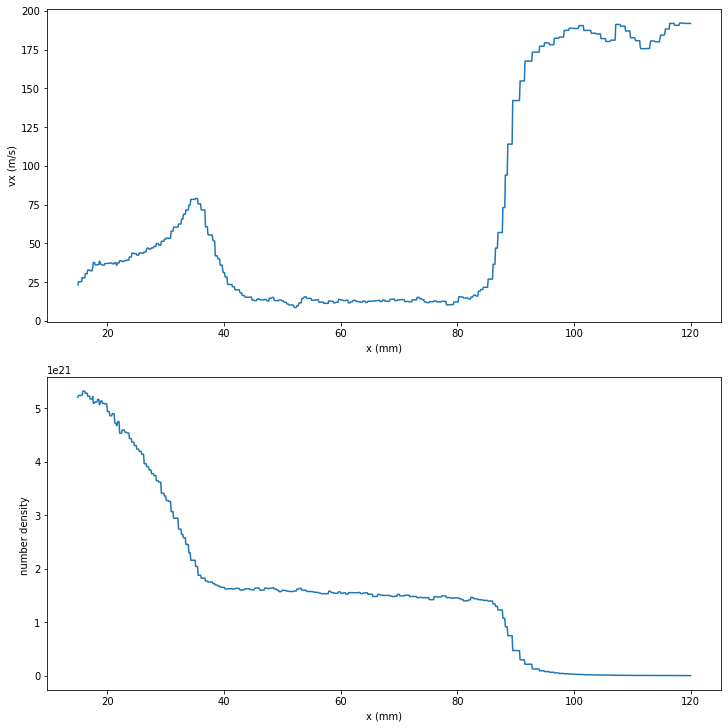

In [49]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

FF = 'flows/T_Cell/DS2t2vn.DAT'
#flowField = np.loadtxt(filename, skiprows=1)

def set_flow_type(FF):
        '''
        Loads DSMC output file FF and uses bivariate spline method to set gas characteristics
        on a grid of points.

        Args:
        FF is the filename of the DSMC output file (DS2FF.DAT) which should be named in the format
        xyyy.dat, where x denotes the geometry and yyy denotes the gas flow-rate. e.g. f005.dat

        The class instance will update the following attributes:
        # self._geometry: cell geometry, denoted by a single letter ('f', 'g', 'h', etc)
        # self._flowrate: buffer gas flowrate of the DSMC simulation, in SCCM.

        # self._fDens, self._fTemp, self._fVz, self._fVr, self._fVp: the scipy.interpolate objects
        corresponding to the density, temperature, etc. on the grid.

        **IMPORTANT: this method needs to be updated with each new designed cell geometry, depending
        on the desired size and coarseness of the simulation site.
        '''
        try:
            #Geometry is a string in ['fCell', 'gCell', 'hCell', ..., 'pCell', 'rCell', ...]
            #Flowrate is an integer in [2, 5, ..., 200] (SCCM)

            geometry = 'tCell'

            # print("Loading flow field: geometry {0}, flowrate {1} SCCM".format(geometry,self._flowrate))

            flowField = np.loadtxt(FF, skiprows=1) # Assumes only first row is not data.

            zs, rs, dens, temps = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7] #Arrays of z and r coordinates, density and temperature
            vzs, vrs, vps = flowField[:, 4], flowField[:, 5], flowField[:, 6] #velocity field in z, r, and "perpendicular" directions
            quantHolder = [zs, rs, dens, temps, vzs, vrs, vps]

            if geometry in ['fCell', 'gCell', 'nCell', 'qCell', 'rCell']:
                grid_x, grid_y = np.mgrid[0.010:0.12:2250j, 0:0.030:750j] # high density, to be safe. Was 4500 x 1500 points
            elif geometry in ['hCell', 'jCell', 'kCell', 'mCell']:
                grid_x, grid_y = np.mgrid[0.010:0.24:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['pCell']:
                grid_x, grid_y = np.mgrid[0.010:0.20:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['tCell', 'sCell', 'yCell']: # cases added by Ben, 2/19/2020
                grid_x, grid_y = np.mgrid[0.005:0.12:4500j, 0:0.030:1000j]
            else:
                raise ValueError('Unknown geometry')

            print("Loading grids ... ")
            grid_dens = si.griddata(np.transpose([zs, rs]), np.log(dens + 1.0), (grid_x, grid_y), 'nearest') # the +1.0 inside the log is to make sure the log-density never goes negative.
            grid_temps = si.griddata(np.transpose([zs, rs]), temps, (grid_x, grid_y), 'nearest')
            grid_vzs = si.griddata(np.transpose([zs, rs]), vzs, (grid_x, grid_y), 'nearest')
            grid_vrs = si.griddata(np.transpose([zs, rs]), vrs, (grid_x, grid_y), 'nearest')
            grid_vps = si.griddata(np.transpose([zs, rs]), vps, (grid_x, grid_y), 'nearest')

            print("Interpolating ... ",end='')
            fDens = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_dens, kx=1, ky=1)
            fTemp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_temps, kx=1, ky=1)
            fVz = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vzs, kx=1, ky=1)
            fVr = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vrs, kx=1, ky=1)
            fVp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vps, kx=1, ky=1)

            print("Flow field loaded")
            return fDens, fTemp, fVz, fVr, fVp

        except:
            raise ValueError('Could not load flow field')

            
def dsmc_quant(x0, y0, z0):
        '''
        Return quantity (quant) evaluated at the given location in the cell.

        Note: density is stored as log(dens) in self._fDens, so need to return exp().
        '''
       
        logdens = fDens(z0, (x0**2 + y0**2)**0.5).T[0]
        dens =  np.exp(logdens)


        tem = fTemp(z0, (x0**2 + y0**2)**0.5).T[0]

        Vz = fVz(z0, (x0**2 + y0**2)**0.5).T[0]
        vr = fVr(z0, (x0**2 + y0**2)**0.5).T[0]
        vPerpCw = fVp(z0, (x0**2 + y0**2)**0.5).T[0]
        theta = np.arctan2(y0, x0)
        rot = np.pi/2 - theta
        Vx = np.cos(rot) * vPerpCw + np.sin(rot) * vr
        Vy = -np.sin(rot) * vPerpCw + np.cos(rot) * vr
        
        return dens, tem, Vz, vr, Vx, Vy
    
def Integrand(x,z, fVz1, fDens1):
    return 2*np.pi*x*fVz1(z,x)[0][0]*np.exp(fDens1(z, x)[0][0])
    
    
fDens, fTemp, fVz, fVr, fVp = set_flow_type(FF)

zlinspace = np.linspace(0.015,0.12, 1000)
dens, tem, Vz, vr, Vx, Vy = dsmc_quant(0, 0, zlinspace)

fVz1 = fVz
fDens1 = fDens
z = 0.015
SCCM1 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.035
SCCM2 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.0886
SCCM3 = integrate.quad(Integrand, 0,0.0025, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
print("SCCM value at x = 15 mm", SCCM1 )
print("SCCM value at x = 35 mm", SCCM2 )
print("SCCM value at x = 88.6 mm", SCCM3 )

fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(zlinspace*1000, Vz) 
ax2.plot(zlinspace*1000, dens)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('number density ')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

Loading grids ... 
Interpolating ... Flow field loaded
SCCM value at x = 15 mm 1.5670001955598212
SCCM value at x = 35 mm 1.7320030116625837
SCCM value at x = 88.6 mm 1.6787468684475793
x is the axial direction i.e. the direction that molecules propagate


C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 


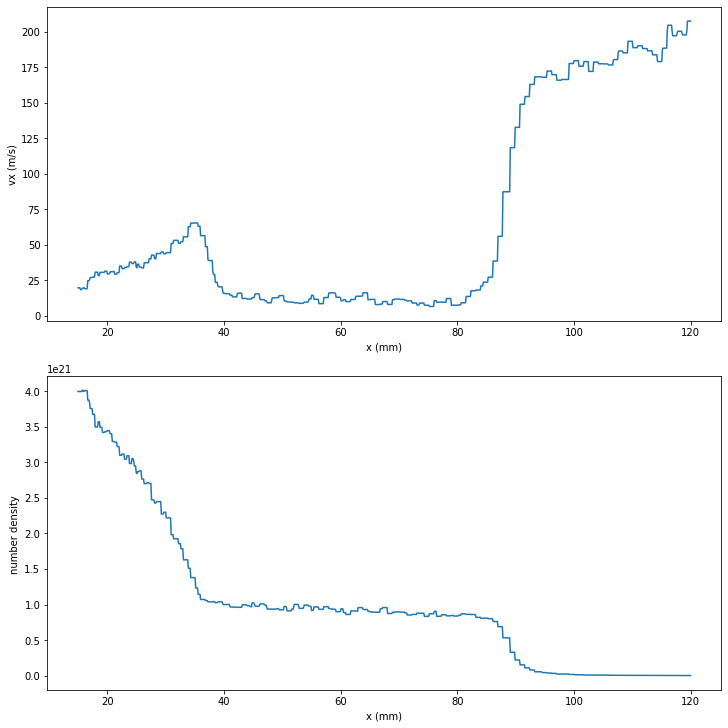

In [51]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

FF = 'flows/T_Cell/DS2halfvn.DAT'
#flowField = np.loadtxt(filename, skiprows=1)

def set_flow_type(FF):
        '''
        Loads DSMC output file FF and uses bivariate spline method to set gas characteristics
        on a grid of points.

        Args:
        FF is the filename of the DSMC output file (DS2FF.DAT) which should be named in the format
        xyyy.dat, where x denotes the geometry and yyy denotes the gas flow-rate. e.g. f005.dat

        The class instance will update the following attributes:
        # self._geometry: cell geometry, denoted by a single letter ('f', 'g', 'h', etc)
        # self._flowrate: buffer gas flowrate of the DSMC simulation, in SCCM.

        # self._fDens, self._fTemp, self._fVz, self._fVr, self._fVp: the scipy.interpolate objects
        corresponding to the density, temperature, etc. on the grid.

        **IMPORTANT: this method needs to be updated with each new designed cell geometry, depending
        on the desired size and coarseness of the simulation site.
        '''
        try:
            #Geometry is a string in ['fCell', 'gCell', 'hCell', ..., 'pCell', 'rCell', ...]
            #Flowrate is an integer in [2, 5, ..., 200] (SCCM)

            geometry = 'tCell'

            # print("Loading flow field: geometry {0}, flowrate {1} SCCM".format(geometry,self._flowrate))

            flowField = np.loadtxt(FF, skiprows=1) # Assumes only first row is not data.

            zs, rs, dens, temps = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7] #Arrays of z and r coordinates, density and temperature
            vzs, vrs, vps = flowField[:, 4], flowField[:, 5], flowField[:, 6] #velocity field in z, r, and "perpendicular" directions
            quantHolder = [zs, rs, dens, temps, vzs, vrs, vps]

            if geometry in ['fCell', 'gCell', 'nCell', 'qCell', 'rCell']:
                grid_x, grid_y = np.mgrid[0.010:0.12:2250j, 0:0.030:750j] # high density, to be safe. Was 4500 x 1500 points
            elif geometry in ['hCell', 'jCell', 'kCell', 'mCell']:
                grid_x, grid_y = np.mgrid[0.010:0.24:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['pCell']:
                grid_x, grid_y = np.mgrid[0.010:0.20:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['tCell', 'sCell', 'yCell']: # cases added by Ben, 2/19/2020
                grid_x, grid_y = np.mgrid[0.005:0.12:4500j, 0:0.030:1000j]
            else:
                raise ValueError('Unknown geometry')

            print("Loading grids ... ")
            grid_dens = si.griddata(np.transpose([zs, rs]), np.log(dens + 1.0), (grid_x, grid_y), 'nearest') # the +1.0 inside the log is to make sure the log-density never goes negative.
            grid_temps = si.griddata(np.transpose([zs, rs]), temps, (grid_x, grid_y), 'nearest')
            grid_vzs = si.griddata(np.transpose([zs, rs]), vzs, (grid_x, grid_y), 'nearest')
            grid_vrs = si.griddata(np.transpose([zs, rs]), vrs, (grid_x, grid_y), 'nearest')
            grid_vps = si.griddata(np.transpose([zs, rs]), vps, (grid_x, grid_y), 'nearest')

            print("Interpolating ... ",end='')
            fDens = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_dens, kx=1, ky=1)
            fTemp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_temps, kx=1, ky=1)
            fVz = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vzs, kx=1, ky=1)
            fVr = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vrs, kx=1, ky=1)
            fVp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vps, kx=1, ky=1)

            print("Flow field loaded")
            return fDens, fTemp, fVz, fVr, fVp

        except:
            raise ValueError('Could not load flow field')

            
def dsmc_quant(x0, y0, z0):
        '''
        Return quantity (quant) evaluated at the given location in the cell.

        Note: density is stored as log(dens) in self._fDens, so need to return exp().
        '''
       
        logdens = fDens(z0, (x0**2 + y0**2)**0.5).T[0]
        dens =  np.exp(logdens)


        tem = fTemp(z0, (x0**2 + y0**2)**0.5).T[0]

        Vz = fVz(z0, (x0**2 + y0**2)**0.5).T[0]
        vr = fVr(z0, (x0**2 + y0**2)**0.5).T[0]
        vPerpCw = fVp(z0, (x0**2 + y0**2)**0.5).T[0]
        theta = np.arctan2(y0, x0)
        rot = np.pi/2 - theta
        Vx = np.cos(rot) * vPerpCw + np.sin(rot) * vr
        Vy = -np.sin(rot) * vPerpCw + np.cos(rot) * vr
        
        return dens, tem, Vz, vr, Vx, Vy
    
def Integrand(x,z, fVz1, fDens1):
    return 2*np.pi*x*fVz1(z,x)[0][0]*np.exp(fDens1(z, x)[0][0])
    
    
fDens, fTemp, fVz, fVr, fVp = set_flow_type(FF)

zlinspace = np.linspace(0.015,0.12, 1000)
dens, tem, Vz, vr, Vx, Vy = dsmc_quant(0, 0, zlinspace)

fVz1 = fVz
fDens1 = fDens
z = 0.015
SCCM1 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.035
SCCM2 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.0886
SCCM3 = integrate.quad(Integrand, 0,0.0025, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
print("SCCM value at x = 15 mm", SCCM1 )
print("SCCM value at x = 35 mm", SCCM2 )
print("SCCM value at x = 88.6 mm", SCCM3 )

fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(zlinspace*1000, Vz) 
ax2.plot(zlinspace*1000, dens)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('number density ')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

In [1]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

FF = 'flows/T_Cell/DS2t2v2n3.DAT'
#flowField = np.loadtxt(filename, skiprows=1)

def set_flow_type(FF):
        '''
        Loads DSMC output file FF and uses bivariate spline method to set gas characteristics
        on a grid of points.

        Args:
        FF is the filename of the DSMC output file (DS2FF.DAT) which should be named in the format
        xyyy.dat, where x denotes the geometry and yyy denotes the gas flow-rate. e.g. f005.dat

        The class instance will update the following attributes:
        # self._geometry: cell geometry, denoted by a single letter ('f', 'g', 'h', etc)
        # self._flowrate: buffer gas flowrate of the DSMC simulation, in SCCM.

        # self._fDens, self._fTemp, self._fVz, self._fVr, self._fVp: the scipy.interpolate objects
        corresponding to the density, temperature, etc. on the grid.

        **IMPORTANT: this method needs to be updated with each new designed cell geometry, depending
        on the desired size and coarseness of the simulation site.
        '''
        try:
            #Geometry is a string in ['fCell', 'gCell', 'hCell', ..., 'pCell', 'rCell', ...]
            #Flowrate is an integer in [2, 5, ..., 200] (SCCM)

            geometry = 'tCell'

            # print("Loading flow field: geometry {0}, flowrate {1} SCCM".format(geometry,self._flowrate))

            flowField = np.loadtxt(FF, skiprows=1) # Assumes only first row is not data.

            zs, rs, dens, temps = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7] #Arrays of z and r coordinates, density and temperature
            vzs, vrs, vps = flowField[:, 4], flowField[:, 5], flowField[:, 6] #velocity field in z, r, and "perpendicular" directions
            quantHolder = [zs, rs, dens, temps, vzs, vrs, vps]

            if geometry in ['fCell', 'gCell', 'nCell', 'qCell', 'rCell']:
                grid_x, grid_y = np.mgrid[0.010:0.12:2250j, 0:0.030:750j] # high density, to be safe. Was 4500 x 1500 points
            elif geometry in ['hCell', 'jCell', 'kCell', 'mCell']:
                grid_x, grid_y = np.mgrid[0.010:0.24:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['pCell']:
                grid_x, grid_y = np.mgrid[0.010:0.20:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['tCell', 'sCell', 'yCell']: # cases added by Ben, 2/19/2020
                grid_x, grid_y = np.mgrid[0.005:0.12:4500j, 0:0.030:1000j]
            else:
                raise ValueError('Unknown geometry')

            print("Loading grids ... ")
            grid_dens = si.griddata(np.transpose([zs, rs]), np.log(dens + 1.0), (grid_x, grid_y), 'nearest') # the +1.0 inside the log is to make sure the log-density never goes negative.
            grid_temps = si.griddata(np.transpose([zs, rs]), temps, (grid_x, grid_y), 'nearest')
            grid_vzs = si.griddata(np.transpose([zs, rs]), vzs, (grid_x, grid_y), 'nearest')
            grid_vrs = si.griddata(np.transpose([zs, rs]), vrs, (grid_x, grid_y), 'nearest')
            grid_vps = si.griddata(np.transpose([zs, rs]), vps, (grid_x, grid_y), 'nearest')

            print("Interpolating ... ",end='')
            fDens = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_dens, kx=1, ky=1)
            fTemp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_temps, kx=1, ky=1)
            fVz = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vzs, kx=1, ky=1)
            fVr = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vrs, kx=1, ky=1)
            fVp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vps, kx=1, ky=1)

            print("Flow field loaded")
            return fDens, fTemp, fVz, fVr, fVp

        except:
            raise ValueError('Could not load flow field')

            
def dsmc_quant(x0, y0, z0):
        '''
        Return quantity (quant) evaluated at the given location in the cell.

        Note: density is stored as log(dens) in self._fDens, so need to return exp().
        '''
       
        logdens = fDens(z0, (x0**2 + y0**2)**0.5).T[0]
        dens =  np.exp(logdens)


        tem = fTemp(z0, (x0**2 + y0**2)**0.5).T[0]

        Vz = fVz(z0, (x0**2 + y0**2)**0.5).T[0]
        vr = fVr(z0, (x0**2 + y0**2)**0.5).T[0]
        vPerpCw = fVp(z0, (x0**2 + y0**2)**0.5).T[0]
        theta = np.arctan2(y0, x0)
        rot = np.pi/2 - theta
        Vx = np.cos(rot) * vPerpCw + np.sin(rot) * vr
        Vy = -np.sin(rot) * vPerpCw + np.cos(rot) * vr
        
        return dens, tem, Vz, vr, Vx, Vy
    
def Integrand(x,z, fVz1, fDens1):
    return 2*np.pi*x*fVz1(z,x)[0][0]*np.exp(fDens1(z, x)[0][0])
    
    
fDens, fTemp, fVz, fVr, fVp = set_flow_type(FF)

zlinspace = np.linspace(0.015,0.12, 1000)
dens, tem, Vz, vr, Vx, Vy = dsmc_quant(0, 0, zlinspace)

fVz1 = fVz
fDens1 = fDens
z = 0.015
SCCM1 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.035
SCCM2 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.0886
SCCM3 = integrate.quad(Integrand, 0,0.0025, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
print("SCCM value at x = 15 mm", SCCM1 )
print("SCCM value at x = 35 mm", SCCM2 )
print("SCCM value at x = 88.6 mm", SCCM3 )

fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(zlinspace*1000, Vz) 
ax2.plot(zlinspace*1000, dens)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('number density ')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

Loading grids ... 
Interpolating ... Flow field loaded
SCCM value at x = 15 mm 1.6168476428119598
SCCM value at x = 35 mm 1.8068811696070823
SCCM value at x = 88.6 mm 1.3978483161309452
x is the axial direction i.e. the direction that molecules propagate


C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 


Loading grids ... 
Interpolating ... Flow field loaded
SCCM value at x = 15 mm 1.9485741572892084
SCCM value at x = 35 mm 2.0151254649601853
SCCM value at x = 88.6 mm 1.9383637064821082
x is the axial direction i.e. the direction that molecules propagate


C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Yuiki Takahashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 


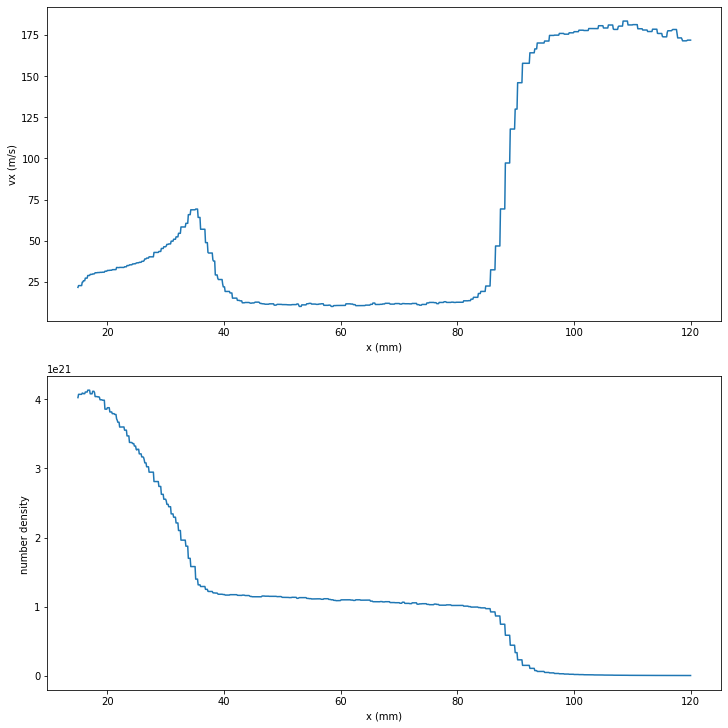

In [2]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

FF = 'flows/T_Cell/DS2t2v3n4.DAT'
#flowField = np.loadtxt(filename, skiprows=1)

def set_flow_type(FF):
        '''
        Loads DSMC output file FF and uses bivariate spline method to set gas characteristics
        on a grid of points.

        Args:
        FF is the filename of the DSMC output file (DS2FF.DAT) which should be named in the format
        xyyy.dat, where x denotes the geometry and yyy denotes the gas flow-rate. e.g. f005.dat

        The class instance will update the following attributes:
        # self._geometry: cell geometry, denoted by a single letter ('f', 'g', 'h', etc)
        # self._flowrate: buffer gas flowrate of the DSMC simulation, in SCCM.

        # self._fDens, self._fTemp, self._fVz, self._fVr, self._fVp: the scipy.interpolate objects
        corresponding to the density, temperature, etc. on the grid.

        **IMPORTANT: this method needs to be updated with each new designed cell geometry, depending
        on the desired size and coarseness of the simulation site.
        '''
        try:
            #Geometry is a string in ['fCell', 'gCell', 'hCell', ..., 'pCell', 'rCell', ...]
            #Flowrate is an integer in [2, 5, ..., 200] (SCCM)

            geometry = 'tCell'

            # print("Loading flow field: geometry {0}, flowrate {1} SCCM".format(geometry,self._flowrate))

            flowField = np.loadtxt(FF, skiprows=1) # Assumes only first row is not data.

            zs, rs, dens, temps = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7] #Arrays of z and r coordinates, density and temperature
            vzs, vrs, vps = flowField[:, 4], flowField[:, 5], flowField[:, 6] #velocity field in z, r, and "perpendicular" directions
            quantHolder = [zs, rs, dens, temps, vzs, vrs, vps]

            if geometry in ['fCell', 'gCell', 'nCell', 'qCell', 'rCell']:
                grid_x, grid_y = np.mgrid[0.010:0.12:2250j, 0:0.030:750j] # high density, to be safe. Was 4500 x 1500 points
            elif geometry in ['hCell', 'jCell', 'kCell', 'mCell']:
                grid_x, grid_y = np.mgrid[0.010:0.24:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['pCell']:
                grid_x, grid_y = np.mgrid[0.010:0.20:9400j, 0:0.030:1500j] # high density, to be safe.
            elif geometry in ['tCell', 'sCell', 'yCell']: # cases added by Ben, 2/19/2020
                grid_x, grid_y = np.mgrid[0.005:0.12:4500j, 0:0.030:1000j]
            else:
                raise ValueError('Unknown geometry')

            print("Loading grids ... ")
            grid_dens = si.griddata(np.transpose([zs, rs]), np.log(dens + 1.0), (grid_x, grid_y), 'nearest') # the +1.0 inside the log is to make sure the log-density never goes negative.
            grid_temps = si.griddata(np.transpose([zs, rs]), temps, (grid_x, grid_y), 'nearest')
            grid_vzs = si.griddata(np.transpose([zs, rs]), vzs, (grid_x, grid_y), 'nearest')
            grid_vrs = si.griddata(np.transpose([zs, rs]), vrs, (grid_x, grid_y), 'nearest')
            grid_vps = si.griddata(np.transpose([zs, rs]), vps, (grid_x, grid_y), 'nearest')

            print("Interpolating ... ",end='')
            fDens = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_dens, kx=1, ky=1)
            fTemp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_temps, kx=1, ky=1)
            fVz = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vzs, kx=1, ky=1)
            fVr = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vrs, kx=1, ky=1)
            fVp = si.RectBivariateSpline(grid_x[:, 0], grid_y[0], grid_vps, kx=1, ky=1)

            print("Flow field loaded")
            return fDens, fTemp, fVz, fVr, fVp

        except:
            raise ValueError('Could not load flow field')

            
def dsmc_quant(x0, y0, z0):
        '''
        Return quantity (quant) evaluated at the given location in the cell.

        Note: density is stored as log(dens) in self._fDens, so need to return exp().
        '''
       
        logdens = fDens(z0, (x0**2 + y0**2)**0.5).T[0]
        dens =  np.exp(logdens)


        tem = fTemp(z0, (x0**2 + y0**2)**0.5).T[0]

        Vz = fVz(z0, (x0**2 + y0**2)**0.5).T[0]
        vr = fVr(z0, (x0**2 + y0**2)**0.5).T[0]
        vPerpCw = fVp(z0, (x0**2 + y0**2)**0.5).T[0]
        theta = np.arctan2(y0, x0)
        rot = np.pi/2 - theta
        Vx = np.cos(rot) * vPerpCw + np.sin(rot) * vr
        Vy = -np.sin(rot) * vPerpCw + np.cos(rot) * vr
        
        return dens, tem, Vz, vr, Vx, Vy
    
def Integrand(x,z, fVz1, fDens1):
    return 2*np.pi*x*fVz1(z,x)[0][0]*np.exp(fDens1(z, x)[0][0])
    
    
fDens, fTemp, fVz, fVr, fVp = set_flow_type(FF)

zlinspace = np.linspace(0.015,0.12, 1000)
dens, tem, Vz, vr, Vx, Vy = dsmc_quant(0, 0, zlinspace)

fVz1 = fVz
fDens1 = fDens
z = 0.015
SCCM1 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.035
SCCM2 = integrate.quad(Integrand, 0,0.002, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
z = 0.0886
SCCM3 = integrate.quad(Integrand, 0,0.0025, args=(z,fVz1, fDens1))[0]/(4.5*10**(17))
print("SCCM value at x = 15 mm", SCCM1 )
print("SCCM value at x = 35 mm", SCCM2 )
print("SCCM value at x = 88.6 mm", SCCM3 )

fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(zlinspace*1000, Vz) 
ax2.plot(zlinspace*1000, dens)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('number density ')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

In [22]:
rs[33132]

0.0

In [29]:
sys.version_info

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)

In [172]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



def random_ball(radius):

        # generate random directions by normalizing the length of a vector of random-normal values
        random_directions = random.normal(size=(3, 1))
        random_directions /= linalg.norm(random_directions, axis=0)

        # gaussian distrbiution over the radius with 3 sigma.
        random_radii = 100 
        while random_radii >3:
            random_radii = abs(random.normal(0,1,1)) 
        # Return the list of random (direction & length) points.
        return radius/3 * (random_directions * random_radii).T

#plt.plot(random_ball(10,1,2)[0])
#random_radii = random.normal(0,1,10000)
#plt.hist(random_radii, bins = 100)
#random_radii = random.normal(0,1,100)
#random_radii[48]
r = random_ball(1)
x,y,z = r[0]
print(x,y,z, r[0])

0.0654620029646231 -0.006927717936900446 0.07178811469857294 [ 0.065462   -0.00692772  0.07178811]


In [49]:
random_ball(100,1,2)[10]

array([1.25001917])

In [251]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t250-1.DAT'
flowField = np.loadtxt(filename, skiprows=1)
area = np.pi * (0.002)**2
#area = 1

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])



j = 0
fluxperarea = 0

for i in range(len(rs)):
    if 0.0349 < zs[i] and zs[i] < 0.035 and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)

flux = fluxperarea/j*area/(4.5*10**(17))
numberdensity = flux*(4.5*10**(17))/(145.508*np.pi*(0.0025)**2)

print("SCCM value at z = 0.035", flux )
print("stagnisation number density", numberdensity )

j = 0
fluxperarea = 0

for i in range(len(rs)):
    if np.equal(0.015,zs[i]) == True and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)
        
flux = fluxperarea/j*area/(4.5*10**(17))
print("SCCM value at z = 0.015", flux )

2797 1.0219300259999997e+23 1
SCCM value at z = 0.035 2.8537669885906
stagnisation number density 4.494840260604226e+20
2845 9.421540470000001e+22 1
2846 9.421540470000001e+22 2
2847 8.32551512e+22 3
2848 8.18828784e+22 4
2849 8.18828784e+22 5
2850 6.2494295e+22 6
SCCM value at z = 0.015 2.317545976948403


In [252]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t250-2.DAT'
flowField = np.loadtxt(filename, skiprows=1)
area = np.pi * (0.002)**2
#area = 1

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])



j = 0
fluxperarea = 0

for i in range(len(rs)):
    if 0.0349 < zs[i] and zs[i] < 0.035 and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)

flux = fluxperarea/j*area/(4.5*10**(17))
numberdensity = flux*(4.5*10**(17))/(145.508*np.pi*(0.0025)**2)

print("SCCM value at z = 0.035", flux )
print("stagnisation number density", numberdensity )

j = 0
fluxperarea = 0

for i in range(len(rs)):
    if np.equal(0.015,zs[i]) == True and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)
        
flux = fluxperarea/j*area/(4.5*10**(17))
print("SCCM value at z = 0.015", flux )

2757 5.85552396e+22 1
SCCM value at z = 0.035 1.6351707605026677
stagnisation number density 2.5754840520108854e+20
2805 5.081569380000001e+22 1
2806 5.081569380000001e+22 2
2807 4.92162352e+22 3
2808 4.5697734e+22 4
2809 4.5697734e+22 5
2810 3.5331479200000004e+22 6
SCCM value at z = 0.015 1.291890711015327


In [253]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t250-3.DAT'
flowField = np.loadtxt(filename, skiprows=1)
area = np.pi * (0.002)**2
#area = 1

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])



j = 0
fluxperarea = 0

for i in range(len(rs)):
    if 0.0349 < zs[i] and zs[i] < 0.035 and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)

flux = fluxperarea/j*area/(4.5*10**(17))
numberdensity = flux*(4.5*10**(17))/(145.508*np.pi*(0.0025)**2)

print("SCCM value at z = 0.035", flux )
print("stagnisation number density", numberdensity )

j = 0
fluxperarea = 0

for i in range(len(rs)):
    if np.equal(0.015,zs[i]) == True and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)
        
flux = fluxperarea/j*area/(4.5*10**(17))
print("SCCM value at z = 0.015", flux )

2911 2.500754032e+23 1
SCCM value at z = 0.035 6.983422662547781
stagnisation number density 1.0999275507051157e+21
2959 1.754200611e+23 1
2960 1.754200611e+23 2
2961 1.665923392e+23 3
2962 1.50546744e+23 4
2963 1.50546744e+23 5
2964 1.300938523e+23 6
SCCM value at z = 0.015 4.41507703714152


x is the axial direction i.e. the direction that molecules propagate


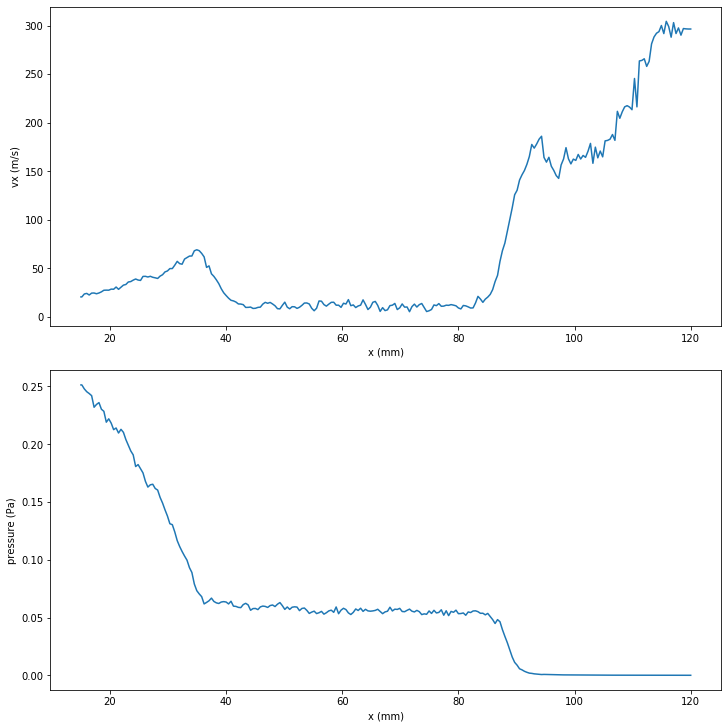

In [248]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t250-1.DAT'
flowField = np.loadtxt(filename, skiprows=1)

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])

pre = []
vx = []
z = []
r = []

for i in range(len(rs)):
    #if rs[i] < 0.000001*10**(-4):
    #if rs[i] == 0:
    if np.equal(0,rs[i]) == True:
        z.append(1000*zs[i])
        vx.append(vxs[i])
        pre.append(pres[i])
        r.append(rs[i])
        #print(i)



fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(z, vx) 
#ax1.legend()
ax2.plot(z, pre)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('pressure (Pa)')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

x is the axial direction i.e. the direction that molecules propagate


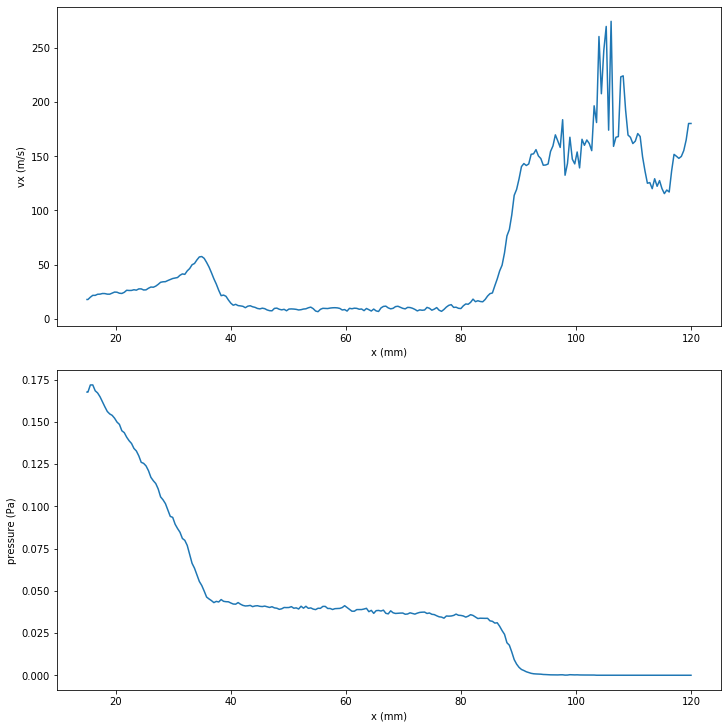

In [249]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t250-2.DAT'
flowField = np.loadtxt(filename, skiprows=1)

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])

pre = []
vx = []
z = []
r = []

for i in range(len(rs)):
    #if rs[i] < 0.000001*10**(-4):
    #if rs[i] == 0:
    if np.equal(0,rs[i]) == True:
        z.append(1000*zs[i])
        vx.append(vxs[i])
        pre.append(pres[i])
        r.append(rs[i])
        #print(i)



fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(z, vx) 
#ax1.legend()
ax2.plot(z, pre)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('pressure (Pa)')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

x is the axial direction i.e. the direction that molecules propagate


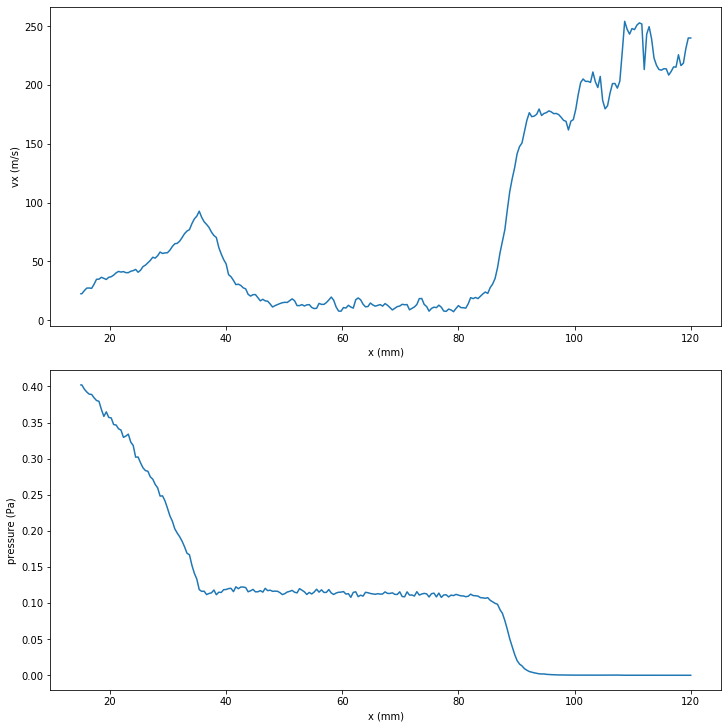

In [250]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t250-3.DAT'
flowField = np.loadtxt(filename, skiprows=1)

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])

pre = []
vx = []
z = []
r = []

for i in range(len(rs)):
    #if rs[i] < 0.000001*10**(-4):
    #if rs[i] == 0:
    if np.equal(0,rs[i]) == True:
        z.append(1000*zs[i])
        vx.append(vxs[i])
        pre.append(pres[i])
        r.append(rs[i])
        #print(i)



fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(z, vx) 
#ax1.legend()
ax2.plot(z, pre)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('pressure (Pa)')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

x is the axial direction i.e. the direction that molecules propagate


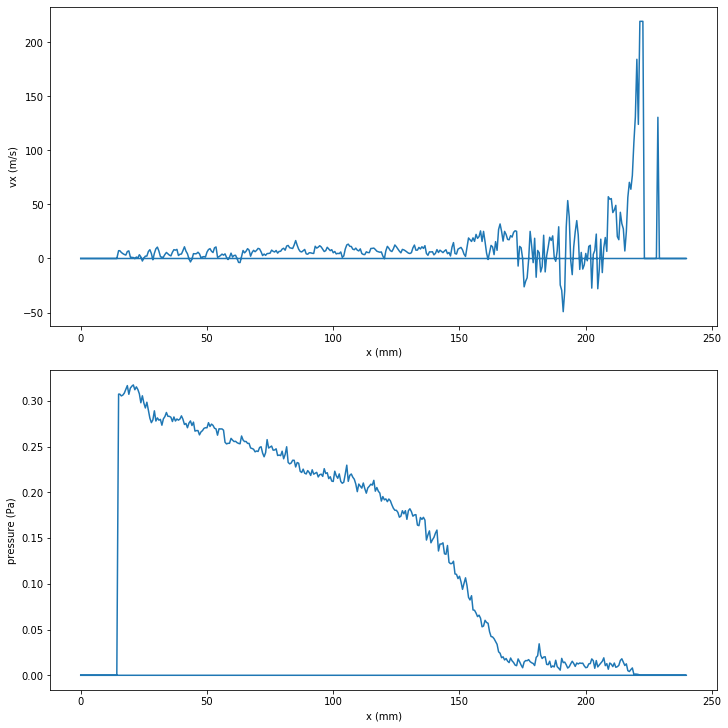

In [254]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t250-4.DAT'
flowField = np.loadtxt(filename, skiprows=1)

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])

pre = []
vx = []
z = []
r = []

for i in range(len(rs)):
    #if rs[i] < 0.000001*10**(-4):
    #if rs[i] == 0:
    if np.equal(0,rs[i]) == True:
        z.append(1000*zs[i])
        vx.append(vxs[i])
        pre.append(pres[i])
        r.append(rs[i])
        #print(i)



fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(z, vx) 
#ax1.legend()
ax2.plot(z, pre)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('pressure (Pa)')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

x is the axial direction i.e. the direction that molecules propagate


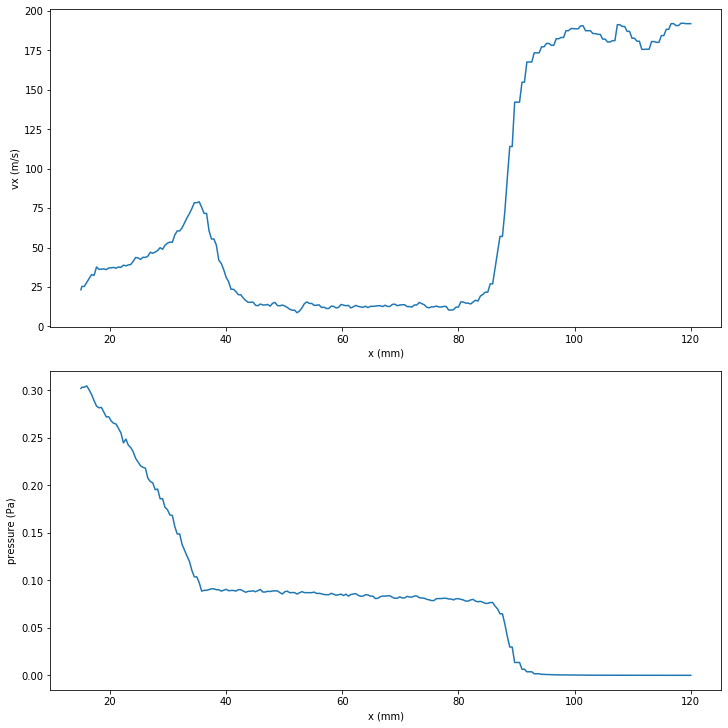

In [2]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t2vn.DAT'
flowField = np.loadtxt(filename, skiprows=1)

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])

pre = []
vx = []
z = []
r = []

for i in range(len(rs)):
    #if rs[i] < 0.000001*10**(-4):
    #if rs[i] == 0:
    if np.equal(0,rs[i]) == True:
        z.append(1000*zs[i])
        vx.append(vxs[i])
        pre.append(pres[i])
        r.append(rs[i])
        #print(i)



fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(z, vx) 
#ax1.legend()
ax2.plot(z, pre)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('pressure (Pa)')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

x is the axial direction i.e. the direction that molecules propagate


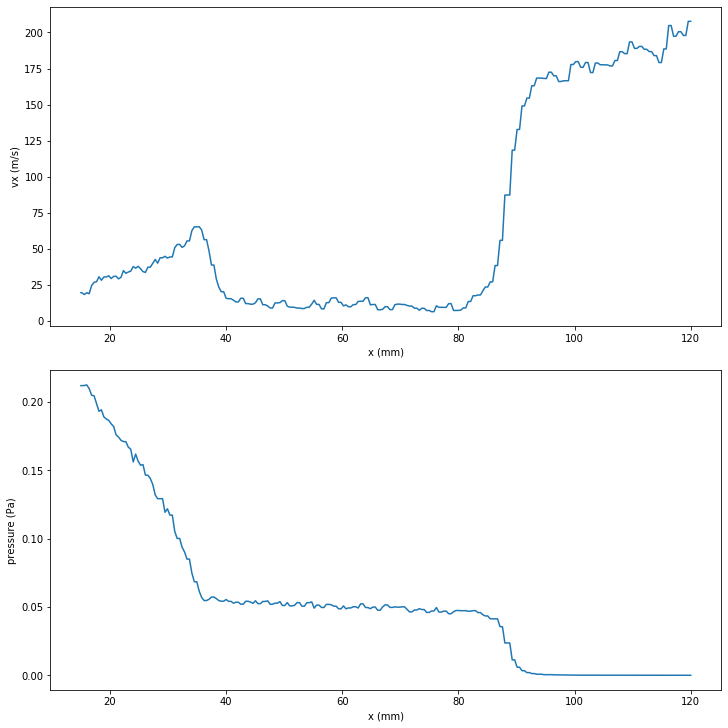

In [4]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2halfvn.DAT'
flowField = np.loadtxt(filename, skiprows=1)

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])

pre = []
vx = []
z = []
r = []

for i in range(len(rs)):
    #if rs[i] < 0.000001*10**(-4):
    #if rs[i] == 0:
    if np.equal(0,rs[i]) == True:
        z.append(1000*zs[i])
        vx.append(vxs[i])
        pre.append(pres[i])
        r.append(rs[i])
        #print(i)



fig, axes = plt.subplots(2,1,figsize=(10,10), constrained_layout=True)
ax1,ax2= axes
ax1.plot(z, vx) 
#ax1.legend()
ax2.plot(z, pre)
ax1.set_ylabel('vx (m/s)')
ax1.set_xlabel('x (mm)')
ax2.set_ylabel('pressure (Pa)')
ax2.set_xlabel('x (mm)')
#print("5SCCM  Note: there is a refrector between 25 and 26 mm")
print("x is the axial direction i.e. the direction that molecules propagate")

In [5]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2t2vn.DAT'
flowField = np.loadtxt(filename, skiprows=1)
area = np.pi * (0.002)**2
#area = 1

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])



j = 0
fluxperarea = 0

for i in range(len(rs)):
    if 0.0349 < zs[i] and zs[i] < 0.035 and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)

flux = fluxperarea/j*area/(4.5*10**(17))
numberdensity = flux*(4.5*10**(17))/(145.508*np.pi*(0.0025)**2)

print("SCCM value at z = 0.035", flux )
print("stagnisation number density", numberdensity )

j = 0
fluxperarea = 0

for i in range(len(rs)):
    if np.equal(0.015,zs[i]) == True and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)
        
flux = fluxperarea/j*area/(4.5*10**(17))
print("SCCM value at z = 0.015", flux )

3455 1.693953612e+23 1
SCCM value at z = 0.035 4.730410864872084
stagnisation number density 7.450657776067294e+20
3503 1.2094482040000001e+23 1
3504 1.2094482040000001e+23 2
3505 1.208785068e+23 3
3506 1.128491364e+23 4
3507 1.062749025e+23 5
3508 1.03272473e+23 6
SCCM value at z = 0.015 3.188901127088225


In [6]:
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
from joblib import Parallel, delayed
import itertools
import argparse
import sys
import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filename = 'flows/T_Cell/DS2halfvn.DAT'
flowField = np.loadtxt(filename, skiprows=1)
area = np.pi * (0.002)**2
#area = 1

#Arrays of z and r coordinates, density and temperature
zs, rs, dens, temps, vxs, pres = flowField[:, 0], flowField[:, 1], flowField[:, 2], flowField[:, 7], flowField[:, 4], flowField[:, 18]

#print(rs[33132])



j = 0
fluxperarea = 0

for i in range(len(rs)):
    if 0.0349 < zs[i] and zs[i] < 0.035 and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)

flux = fluxperarea/j*area/(4.5*10**(17))
numberdensity = flux*(4.5*10**(17))/(145.508*np.pi*(0.0025)**2)

print("SCCM value at z = 0.035", flux )
print("stagnisation number density", numberdensity )

j = 0
fluxperarea = 0

for i in range(len(rs)):
    if np.equal(0.015,zs[i]) == True and rs[i] < 0.002:        
        
        fluxperarea += dens[i]*vxs[i]
        
        j += 1
        
        print(i, dens[i]*vxs[i], j)
        
flux = fluxperarea/j*area/(4.5*10**(17))
print("SCCM value at z = 0.015", flux )

2364 8.999877860000002e+22 1
SCCM value at z = 0.035 2.513240014949461
stagnisation number density 3.958491512769058e+20
2412 7.84913283e+22 1
2413 6.499414550000001e+22 2
2414 6.499414550000001e+22 3
2415 6.27513355e+22 4
2416 5.8078425e+22 5
2417 4.78978266e+22 6
SCCM value at z = 0.015 1.755602057047954


In [54]:
file_ext = 'site'
if file_ext[0] in ['t']:

    print(10)